<a href="https://colab.research.google.com/github/bayartsogt-ya/albert-mongolian/blob/master/ALBERT_Mongolian_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using ALBERT-Mongolian

Сайн байна уу?

Энэхүү notebook нь [`ALBERT-Mongolian`](https://huggingface.co/bayartsogt/albert-mongolian) ашиглан хэрхэн `TF Keras` дээр текст ангилал хийхийг харуулах болно.

Notebook-ийн төгсгөлд та eduge.mn сайтын мэдээний өгөгдлийг **~90%** таах чадвартай модельтэй болох ба энэхүү үр дүн нь ердөө эхлэл ба цааш сайжрах бүрэн боломжтой юм.

Notebook-ийн дараалал:

1. [Бэлтгэл ажил](#scrollTo=caMvdHeDJGOx)
2. [Өгөгдөл](#scrollTo=lUXesMU1c5Sq)
3. [Tokenize хийх](#scrollTo=PJsBXhkvc7L5)
4. [Модель ба сургалт](#scrollTo=1LEnvmjDdNlZ)
5. [Үр дүн](#scrollTo=FmJPTVHI4E6g)

```
used lang: python 3.6
TF version: 2.1
author: Bayartsogt Yadamsuren
```


## Бэлтгэл ажил

In [1]:
! pip install -q transformers
! pip install -q tensorflow==2.1.0 # 2.2 дээр тест хийгээгүй болно!

     |████████████████████████████████| 778kB 3.3MB/s 
     |████████████████████████████████| 3.0MB 11.6MB/s 
     |████████████████████████████████| 890kB 17.4MB/s 
     |████████████████████████████████| 1.1MB 19.3MB/s 
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 4.5MB/s 
     |████████████████████████████████| 450kB 25.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1627a30eb70b0869832dc923f358a951a47c0ed01954a9ce410e72be46149072
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorfl

Хэрэгтэй сангуудаа import хийж оруулж ирье!

In [2]:
import gc
import logging

import numpy as np
import pandas as pd

from time import time
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from transformers import TFAlbertModel, AlbertTokenizer

from sklearn.model_selection import train_test_split

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.1.0


### TPU-г ачааллая

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment 
    # variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.81.81.218:8470
INFO:tensorflow:Initializing the TPU system: 10.81.81.218:8470


INFO:tensorflow:Initializing the TPU system: 10.81.81.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Өгөгдөл
Энэ удаагийн сургалтыг **Эдүгэ** сайтын дата дээр туршиж үзэцгээе.

Мөн туршилтын датаг [tugstugi/mongolian-nlp](https://github.com/tugstugi/mongolian-nlp) репогоос татаж авсан болно.

In [4]:
# downloading data
! wget https://github.com/tugstugi/mongolian-nlp/raw/master/datasets/eduge.csv.gz
! gunzip eduge.csv.gz

--2020-07-26 09:59:28--  https://github.com/tugstugi/mongolian-nlp/raw/master/datasets/eduge.csv.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tugstugi/mongolian-nlp/master/datasets/eduge.csv.gz [following]
--2020-07-26 09:59:28--  https://raw.githubusercontent.com/tugstugi/mongolian-nlp/master/datasets/eduge.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73951267 (71M) [application/octet-stream]
Saving to: ‘eduge.csv.gz’

eduge.csv.gz        100%[===================>]  70.53M  82.2MB/s    in 0.9s    

2020-07-26 09:59:30 (82.2 MB/s) - ‘eduge.csv.gz’ saved [73951267/73951267]



Энэхүү ажил нь eduge датаг 9 ангилалд хуваах ба хэрвээ та хүсвэл 2 ангилалд буюу binary classification асуудалд ашигласан ч болно

In [155]:
# eduge_data = pd.read_csv("./eduge.csv", nrows=7500) # binary classification болгохыг хүсвэл энэ мөрийг ажиллуулна
eduge_data = pd.read_csv("./eduge.csv")
eduge_data.head(2)

,news,label
0,Киноны кадраас «Юрийн галавын үе» кино проката...,урлаг соёл
1,“Universal” кино компани Жадд Апатоугийн найру...,урлаг соёл


Энэхүү дата доторх *label* утгууд нь: ['урлаг соёл' 'эдийн засаг' 'эрүүл мэнд' 'хууль' 'улс төр' 'спорт'
 'технологи' 'боловсрол' 'байгал орчин']


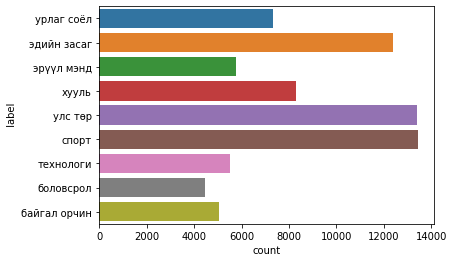

In [70]:
print("Энэхүү дата доторх *label* утгууд нь:", eduge_data[" label"].unique())
sns.countplot(data=eduge_data, y=" label");

Дээрх histogram-аас харахад `спорт, улс төр, эдийн засаг` зэрэг ангилалд 12'000-аас их дата байгаа нь харагдаж байна.

In [71]:
id2label = {i:label for i, label in enumerate(eduge_data[" label"].unique())}
label2id = {label:i for i, label in enumerate(eduge_data[" label"].unique())}
print(id2label)
print(label2id)

{0: 'урлаг соёл', 1: 'эдийн засаг', 2: 'эрүүл мэнд', 3: 'хууль', 4: 'улс төр', 5: 'спорт', 6: 'технологи', 7: 'боловсрол', 8: 'байгал орчин'}
{'урлаг соёл': 0, 'эдийн засаг': 1, 'эрүүл мэнд': 2, 'хууль': 3, 'улс төр': 4, 'спорт': 5, 'технологи': 6, 'боловсрол': 7, 'байгал орчин': 8}


In [72]:
eduge_data[" label"] = eduge_data[" label"].apply(lambda x: label2id[x])
eduge_data.head(2)

,news,label
0,Киноны кадраас «Юрийн галавын үе» кино проката...,0
1,“Universal” кино компани Жадд Апатоугийн найру...,0


Датаныхаа 20%-ийг сургасан моделио тест хийхэд ашиглахаар үлдээе!

In [122]:
# data split
X_train, X_test, y_train, y_test = train_test_split(eduge_data["news"], eduge_data[" label"], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60528,) (15133,) (60528,) (15133,)


## Tokenize хийх

ALBERT-Mongolian-ыг анх сургахдаа хамгийн уртдаа 512 урттай оролт ордог байхаар сургасан ба энэхүү туршилтад ч тэр setting-ээ дагаад MAX_LEN-г 512 оор тохируулж өгье. Ингэснээр 512 оос урт оролт орж ирвэл tokenize хийгээд эхний 512 тэмдэгтийг л цааш модельруу явуулах юм.

In [131]:
MAX_LEN = 512

Доор ALBERT-Mongolian-ийг сургахад ашигласан моделийг оруулж ирж байна.

In [75]:
# read tokenizer
tokenizer = AlbertTokenizer.from_pretrained("bayartsogt/albert-mongolian")

Transformers суурьтай моделийн оролтын хэлбэрийн доор харуулж байна.

In [76]:
# Жишээ + тайлбар
texts = ["Шинэ Монгол ч сайн сургууль шүү"]
texts_encoded = tokenizer.batch_encode_plus(texts, max_length=MAX_LEN, padding=True, truncation=True, return_tensors="np")
print("Жишээ:")
print([tokenizer.cls_token] + tokenizer.tokenize(texts[0]) + [tokenizer.eos_token] + [tokenizer.pad_token])
print(texts_encoded["input_ids"][0])
print(texts_encoded["token_type_ids"][0])
print(texts_encoded["attention_mask"][0])

# sharvaa ахын блогийг энд тавьчихвал амар юм байна!

Жишээ:
['[CLS]', '▁шинэ', '▁монгол', '▁ч', '▁са', 'ин', '▁сургууль', '▁шүү', '[SEP]', '<pad>']
[    2   161   396    19 12331   848   479   164     3]
[0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1]


`[CLS]` тэмдэгт хамгийн урд нэмэгдсэн байгаа. Сургалтыг явцад ALBERT Mongolian-ий бүх гаралтыг бус энэхүү тэмдэгтийг илэрхийлэх векторыг энэхүү оролтыг илэрхүүлнэ гэж үзээд цааш явах юм.

Доорх хүснэгтийн дагуу: 
* `input_ids` гэдэг нь тухайн token-ий index-ийг заана.
* `token_type` гэдэг нь `[SEP]` урд байна уу хойно байн уу гэдгийг заана. Манай тохиолдолд байнга `0` байна
* `attention_mask` гэдэг нь ямар нэг үгийг масклах үгүйг заана. Манай тохиолдолд ямар ч үг масклах буюу нуух шаардагагүй тул бүгд `1` байна.

| |[CLS]|▁шинэ|▁монгол|▁ч|▁са|ин|▁сургууль|▁шүү|[SEP]|
|---|---|---|---|---|---|---|---|---|---|
|input_ids|2|161|396|19|12331|848|479|164|3|
|token_type_ids|0|0|0|0|0|0|0|0|0|
|attention_mask|1|1|1|1|1|1|1|1|1|



In [77]:
%%time
X_train_encoded = tokenizer.batch_encode_plus(list(X_train), max_length=MAX_LEN, padding=True, truncation=True, return_tensors="np")
X_test_encoded  = tokenizer.batch_encode_plus(list(X_test), max_length=MAX_LEN, padding=True, truncation=True, return_tensors="np")

print("size:", X_train_encoded["input_ids"].shape)
print("size:", X_test_encoded["input_ids"].shape)

size: (60528, 512)
size: (15133, 512)
CPU times: user 4min 48s, sys: 12.9 s, total: 5min 1s
Wall time: 5min 2s


## Модель ба сургалт

In [123]:
print("нийт ангилалын тоо:", len(label2id))

нийт ангилалын тоо: 9


Сонгосон архитектур нь:

`INPUT(512) => ALBERT-MONGOLIAN(768) => DENSE_LAYER(9)`

ба ALBERT-Mongolian-ийг transformers-санг ашиглан дуудаж оруулж ирсэн байна.

In [145]:
def build_model():

    with strategy.scope(): # TPU RAM дээр модель оо үүсгэх үед ашиглана
        ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
        att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
        tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

        bert_model = TFAlbertModel.from_pretrained('bayartsogt/albert-mongolian')
        
        x = bert_model(ids, attention_mask=att, token_type_ids=tok)[1] # getting class token value
        x = tf.keras.layers.Dropout(0.2)(x)
        
        if len(label2id) == 2:
            x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
        else:
            x = tf.keras.layers.Dense(len(label2id), activation="softmax")(x)
        
        model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x])

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
        loss_name = "binary_crossentropy" if len(label2id) == 2 else "sparse_categorical_crossentropy"

        print("Loss:", loss_name)
        model.compile(loss=loss_name, 
                      optimizer=optimizer, 
                      metrics=["accuracy"])

    return model

In [146]:
tf.keras.backend.clear_session()
tf.tpu.experimental.initialize_tpu_system(tpu)

model = build_model()
model.summary()

INFO:tensorflow:Initializing the TPU system: 10.81.81.218:8470


INFO:tensorflow:Initializing the TPU system: 10.81.81.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Loss: sparse_categorical_crossentropy
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) ((None, 512, 768), ( 11683584    input_1[0][0]                    
________________________________________________________

### Сургалт
Дээрх моделио ашиглан сургалт хийе.
Энэхүү хэсэгт та early stopping, learning rate scheduler зэрэг арга ашиглан үр дүнг сайжруулах бүрэн боломжтой юм.

Сургалт хэрхэн явж байгаа хянахын тулд сургалтад бэлдсэн датаныхаа 80%-ийг train-нд 20%-ийг validation хийхэд ашиглая.

In [ ]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 5
VAL_SPLIT = 0.2

STEPS_PER_EPOCH = int(X_train_encoded["input_ids"].shape[0] * (1-VAL_SPLIT) / BATCH_SIZE)

history = model.fit(x=[X_train_encoded["input_ids"], X_train_encoded["attention_mask"], X_train_encoded["token_type_ids"]], 
                    y=[np.array(y_train)], 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=VAL_SPLIT,
                    verbose=1)

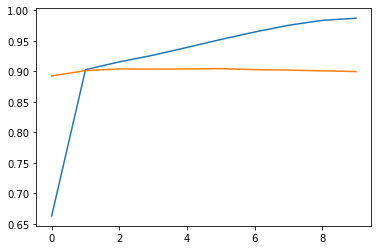

In [148]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Дээрх графикаас харахад манай модель дөнгөж эхлээд л overfit болсон харагдаж байна.

Энд байга код нь ойлгоход амар байлгах үүднээс overfit-ийг багасгах ямар нэг арга хэрэглээгүй болно.

Та өөрийн drive дээрээ хуулаад дуртайгаараа тоглох боломжтой байгаа.

In [149]:
# хадгалах
file_path = "albert-mongolian-finetuned.hdf5"
model.save_weights(file_path)

In [150]:
del model
gc.collect()

30219

## Үр дүн

Одоо сургасан моделоо ашиглаад тест дата дээр хэрхэн таамаглал хийж байгааг харцгаая!

In [151]:
trained_model = build_model()
trained_model.load_weights(file_path)

- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Loss: sparse_categorical_crossentropy


In [152]:
prediction = trained_model.predict(x=[X_test_encoded["input_ids"], X_test_encoded["attention_mask"], X_test_encoded["token_type_ids"]], batch_size=16, verbose=1)

15133/15133 [==============================] - 68s 4ms/sample


In [153]:
# prediction
from sklearn.metrics import classification_report

if len(label2id) == 2:
    threshold = 0.5
    y_pred = np.where(prediction>threshold, 1, 0)
else:
    y_pred = np.argmax(prediction, 1)
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1457
           1       0.83      0.88      0.86      2509
           2       0.89      0.92      0.90      1159
           3       0.89      0.87      0.88      1651
           4       0.92      0.85      0.89      2647
           5       0.98      0.98      0.98      2736
           6       0.88      0.93      0.91      1102
           7       0.80      0.80      0.80       873
           8       0.85      0.83      0.84       999

    accuracy                           0.90     15133
   macro avg       0.89      0.89      0.89     15133
weighted avg       0.90      0.90      0.90     15133



Модель ~90%-ийн нарийвчлалтай ажиллаж байна. Энэхүү үр дүн нь бага зэргийн өөрчлөлтөөр сайжрах бүрэн боломжтой юм.

Одоогоор хамгийн сайн F1 score той байгаа ангилалууд нь `спорт, урлаг соёл, технологи` байгаа бол хамгийн муу нь `боловсрол, байгаль орчин, эдийн засаг` байна.

Энэхүү notebook-ээр та бүхэнд albert-mongolian-ийг хэрхэн fine-tuning хийх буюу өөр төрлийн асуудалд ашиглах талаар харууллаа.

Танд ямар асуух, лавлах зүйл байгаа бол доорх хаягаар холбогдох боломжтой юм.

<h1 style="text-align:center">Анхаарал тавьсан баярлалаа! Enjoy!<h1>

|contact|url|
|--|--|
|E-mail  |mailto:bayartsogt@mn.data-artist.com|
|Github  |https://github.com/bayartsogt-ya|
|Website |https://bayartsogt-ya.github.io|
|LinkedIn|https://www.linkedin.com/in/bayartsogt-yadamsuren-b419b217b/|
